# Jupyter Notebook to Analyze ERA5 100m Wind data

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

Product type:Reanalysis

Variable: 100m u-component of wind, 100m v-component of wind, 10m u-component of wind, 10m v-component of wind

Year: 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023

Month: January, February, March, April, May, June, July, August, September, October, November, December

Day: 01, 02, 03, 04, 05, 06, 07, 08, 09, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31

Time: 00:00, 01:00, 02:00, 03:00, 04:00, 05:00, 06:00, 07:00, 08:00, 09:00, 10:00, 11:00, 12:00, 13:00, 14:00, 15:00, 16:00, 17:00, 18:00, 19:00, 20:00, 21:00, 22:00, 23:00

Sub-region extraction: North 55°, West 6°, South 47°, East 15°

Format: NetCDF (experimental)

### Read in the data

In [7]:
f = xr.open_dataset('/Users/angelina/Documents/Arbeit/ClimateRisk/dataset_2012-2023.nc')
#f = xr.open_dataset('/Users/angelina/Documents/Arbeit/ClimateRisk/dataset_2012-2023_925hPa.nc')

#f = xr.concat([f4, f3, f2, f1], dim='time')
#f.to_netcdf('/Users/angelina/Documents/Arbeit/ClimateRisk/dataset_2012-2023.nc')

In [9]:
lons = f.variables['longitude'][:]  # longitude
lats = f.variables['latitude'][:]  # latitude
u100 = f.variables['u100'][:,:,:,0] # u-wind at 100m height
v100 = f.variables['v100'][:,:,:,0]  # v-wind at 100m height
u10 = f.variables['u10'][:,:,:,0]  # u-wind at 10m height
v10 = f.variables['v10'][:,:,:,0]  # v-wind at 10m height
time = f.variables['time'][:]

ws100 = np.array(np.sqrt(u100*u100+v100*v100))
ws10 = np.array(np.sqrt(u10*u10+v10*v10))

##u_tmp = u[~np.isnan(u[:,1,0,0,0])]
#print(lons)
#print(u100)
##f.close()
##print(f['v10'])

### Plots

In [ ]:
m = Basemap(llcrnrlon=5,llcrnrlat=47,urcrnrlon=15,urcrnrlat=55,
             resolution='i', projection='tmerc', lat_0 = 80, lon_0 = 20)

lon, lat = np.meshgrid(lons, lats)
xi, yi = m(lon, lat)

#define two locations
loc1 = 15
loc2 = 25
#loc3 = 1
#loc4 = 16

x1,y1 = m(lon[loc1,loc1], lat[loc1,loc1])
x2,y2 = m(lon[loc2,loc2], lat[loc2,loc2])
#x3,y3 = m(lon[loc3,loc3], lat[loc3,loc3])
#x4,y4 = m(lon[loc4,loc4], lat[loc4,loc4])

cs = m.pcolor(xi,yi,np.squeeze(ws100[10,:,:]))

m.drawcoastlines()
m.drawmapboundary()
m.drawcountries()
cbar = m.colorbar(cs, location='right', pad="10%")
tt = np.array(time[10], dtype='datetime64[m]') #10 & 4378
plt.title('wind speed in m/s at 100m height; time = '+str(tt))
plt.xlabel('longitude')
plt.ylabel('latitude')
#plt.plot(xi[lon1,lon1], yi[lat1,lat1],'ro')
#plt.plot(x1, y1,'ro')
#plt.plot(x2, y2,'ro')
#plt.plot(x3, y3,'ro')
#plt.plot(x4, y4,'ro')
plt.show()

In [ ]:
loc1=1
plt.figure(figsize=(20,5))
plt.plot(time[:],ws100[:,loc1,loc1])
sel_lon = np.array(lons[loc1])
sel_lat = np.array(lats[loc1])
plt.title('Longitude = '+str(sel_lon)+'; Latitude = '+str(sel_lat))
plt.ylabel('wind speed in m/s')
plt.xlabel('time')
plt.show()

plt.figure(figsize=(20,5))
plt.plot(time[:],ws100[:,loc2,loc2],)
sel_lon = np.array(lons[loc2])
sel_lat = np.array(lats[loc2])
plt.title('Longitude = '+str(sel_lon)+'; Latitude = '+str(sel_lat))
plt.ylabel('wind speed in m/s')
plt.xlabel('time')
#plt.yscale('log')
plt.show()

## Deseasonalization, Principal Component Analysis and Correlation

In [ ]:
from scipy.optimize import curve_fit 

def time_as_year_fraction(time):
    first_date=time[:][0].values 
    diff_in_sec = ((time[:][:].values-first_date)) / np.timedelta64(1, 's')
    time_frac = diff_in_sec / (365*24*60*60) #days, hours, minutes, seconds
    return time_frac
    #year = first_date.astype('datetime64[Y]').astype(int) + 1970
    #month = first_date.astype('datetime64[M]').astype(int) % 12 + 1
    #day = (first_date.astype('datetime64[D]') - first_date.astype('datetime64[M]')).astype(int) + 1

def deseasonalize_data(time, data, loc1, loc2=None, plot=False): #time=time_frac, data=ws100

    def sin_func(x,a,b,c,d):
        return a * np.sin(b * x + c) + d
    
    def monthly_func(x, *args):
        a = (x*365/31) #month
        b = np.full(a.shape, args[11])
        for i in range(11, 0, -1):
            b[a<i] = args[i-1]
        return b

    if loc2 is None:
        loc2 = loc1
    
    nan_idx = np.argwhere(~np.isnan(data[:,loc1,loc2])).T[0] #index of all not nan values
    xdata = time[nan_idx]
    ydata = data[nan_idx, loc1, loc2]
    time_shifted = np.copy(xdata) % 1

    popt, _ = curve_fit(monthly_func, time_shifted, ydata, p0=[1]*12)#, bounds=([-1., -1., -10., 0.], [3., 3., 10., 10.,])) #pcov, info, msg, ier: p0=[1,1,1,1], full_output=True
    ydata_deseasonalized = ydata - monthly_func(time_shifted, *popt)

    if plot:
        plt.figure(figsize=(15,5))
        plt.plot(xdata, ydata, label='data')
        plt.plot(xdata, monthly_func(time_shifted, *popt), label='monthly_avg')#, label='fit: a=%5.3f, b=%5.3f, c=%5.3f, d=%5.3f' % tuple(popt))
        plt.plot(xdata, ydata_deseasonalized, label='deseasonalized data', alpha=0.7)
        plt.xlabel('time')
        plt.ylabel('wind speed in m/s')
        plt.legend()
        plt.show()

    return ydata_deseasonalized, popt

In [ ]:
loc1 = 15
loc2 = 25
locs = [1,15,16,25]

In [ ]:
time_frac = time_as_year_fraction(time)

### Deseasonalization Plots

In [ ]:
#scatter plot at different locations
fig = plt.figure(figsize=(12,12))
a = 0
for i,k in enumerate(locs):
    for j,l in enumerate(locs):
        ws100_loc1 = ws100[:,k,k]
        ws100_loc2 = ws100[:,l,l]
        a += 1
        ax1 = fig.add_subplot(len(locs), len(locs),a)
        ax1.title.set_text('loc: '+str(k)+', '+str(l))
        plt.plot(ws100_loc1, ws100_loc2, '.', alpha=0.1)
        plt.tight_layout()
plt.tight_layout()
plt.show()

In [ ]:
ws100_deseasonalized, monthly_params = deseasonalize_data(time=time_frac, data=ws100, loc1=loc1, plot=True)
print(monthly_params)

In [ ]:
fig, axs = plt.subplots(1,3, figsize=(18,4))
for loc1 in locs:
    df = pd.DataFrame({'time': time, 'value': ws100[:,loc1,loc1], 'mean': ws100[:,loc1,loc1], 'mean_error': ws100[:,loc1,loc1], 'var': ws100[:,loc1,loc1]})
    dfmonth = df['time'].dt.month
    dfyear = df['time'].dt.year
    for i in range(1,13):
        mean = (df[dfmonth == i]['value'].mean())
        var = (df[dfmonth == i]['value'].std())
        df.loc[dfmonth == i,'mean'] = mean
        df.loc[dfmonth == i,'mean_error'] -= mean
        df.loc[dfmonth == i,'var'] = var
    time_plot = df[dfyear==2022]['time']
    axs[0].plot(time_plot, df[dfyear==2022]['var'], label='location: '+str(loc1))
    axs[0].legend(loc="upper right")
    axs[0].set_title('Std. dev.')
    axs[1].plot(time_plot, df[dfyear==2022]['mean'])
    axs[1].set_title('Mean')
    axs[2].plot(time_plot, df[dfyear==2022]['var']/df[dfyear==2022]['mean'])
    axs[2].set_title('Std. dev. / Mean')
    #plt.plot(df['time'], df['var'], label='location: '+str(loc1))
plt.tight_layout()
plt.show()

#last loc only
plt.figure(figsize=(12,4))
plt.hist(df[dfmonth==1]['mean_error'], bins=100, alpha=0.5, density=True, label='January')
plt.hist(df[dfmonth==8]['mean_error'], bins=100, alpha=0.5, density=True, label='August')
plt.legend()
plt.title('Histogram of mean error in specific month')
plt.show()

In [ ]:
roll_window = [1,12,24]
for i in (roll_window):
    df = pd.DataFrame({'data': ws100[:,loc1,loc1]})
    df['moving_avg'] = df['data'].shift(-1).rolling(i).mean() 
    df['data_w/o_moving_avg'] = df['data']-df['moving_avg']
    df.plot(figsize=(20,5));

    plt.figure(figsize=(8,4))
    plt.hist(df['data_w/o_moving_avg'], density=True, bins=50)
    plt.title('Histogram of wind speed over time w/o moving average')
    plt.show()

    from statsmodels.graphics.tsaplots import plot_acf
    nan_idx = np.argwhere(~np.isnan(df['data_w/o_moving_avg'])).T[0] #11:-1545
    plot_acf(df['data_w/o_moving_avg'][nan_idx]);

In [ ]:
roll_window = [1,12,24]
for i in (roll_window):
    fig, axs = plt.subplots(1,3, figsize=(15,4))

    for loc1 in locs:
        nan_idx = np.argwhere(~np.isnan(ws100[:,loc1,loc1])).T[0]
        df = pd.DataFrame({'data': ws100[nan_idx,loc1,loc1]})
        df['moving_avg'] = df['data'].shift(-1).rolling(i).mean() #6,12,24h
        df['data_w/o_moving_avg'] = df['data']-df['moving_avg']
        
        df = pd.DataFrame({'time': time[nan_idx], 'value': df['data_w/o_moving_avg'], 'mean': df['data_w/o_moving_avg'], 'mean_error': df['data_w/o_moving_avg'], 'var': df['data_w/o_moving_avg']})
        dfmonth = df['time'].dt.month
        dfyear = df['time'].dt.year
        for i in range(1,13):
            mean = (df[dfmonth == i]['value'].mean())
            var = (df[dfmonth == i]['value'].std())
            df.loc[dfmonth == i,'mean'] = mean
            df.loc[dfmonth == i,'mean_error'] -= mean
            df.loc[dfmonth == i,'var'] = var
        time_plot = df[dfyear==2022]['time']
        axs[0].plot(time_plot, df[dfyear==2022]['var'], label='location: '+str(loc1))
        axs[0].legend()
        axs[0].set_title('Std. dev.')
        axs[1].plot(time_plot, df[dfyear==2022]['mean'])
        axs[1].set_title('Mean')
        axs[2].hist(df[dfmonth==1]['mean_error'], bins=100, alpha=0.5, density=True, label='January, loc: '+str(loc1))
        axs[2].hist(df[dfmonth==8]['mean_error'], bins=100, alpha=0.5, density=True, label='August, loc: '+str(loc1))
        axs[2].legend()
        axs[2].set_title('Mean error')
    plt.tight_layout()
    plt.show()

In [ ]:
fig = plt.figure(figsize=(12,12))
a = 0
for i,k in enumerate(locs):
    for j,l in enumerate(locs):
        df_loc1 = pd.DataFrame({'data': ws100[:,k,k]})
        df_loc2 = pd.DataFrame({'data': ws100[:,l,l]})
        df_loc1['moving_avg'] = df_loc1['data'].shift(1).rolling(window=24).mean() 
        df_loc1['data_w/o_moving_avg'] = df_loc1['data']-df_loc1['moving_avg']
        df_loc2['moving_avg'] = df_loc2['data'].shift(1).rolling(window=24).mean() 
        df_loc2['data_w/o_moving_avg'] = df_loc2['data']-df_loc2['moving_avg']
        a += 1
        ax1 = fig.add_subplot(len(locs), len(locs),a)
        ax1.title.set_text('loc: '+str(k)+', '+str(l))
        plt.plot(df_loc1['data_w/o_moving_avg'], df_loc2['data_w/o_moving_avg'], '.', alpha=0.1)
        plt.tight_layout()
plt.title('Scatter Plot at different locations')
plt.show()

In [ ]:
# by hours
if False:
    ws100_deseasonalized, monthly_params = deseasonalize_data(time=time_frac, data=ws100, loc1=loc1)
    time_nan = time[np.argwhere(~np.isnan(ws100[:,loc1,loc1])).T[0] ]

    df = pd.DataFrame({'time': time_nan, 'value': ws100_deseasonalized, 'mean': ws100_deseasonalized, 'mean_error': ws100_deseasonalized, 'var': ws100_deseasonalized})
    df2 = pd.DataFrame({'time': time, 'value': ws100[:,loc1,loc1], 'mean': ws100[:,loc1,loc1], 'mean_error': ws100[:,loc1,loc1], 'var': ws100[:,loc1,loc1]})

    dfhour = df['time'].dt.hour
    df2hour = df2['time'].dt.hour

    for i in range(np.unique(dfhour)[-1]+1):
        mean = (df[dfhour == i]['value'].mean())
        mean2 = (df2[df2hour == i]['value'].mean())
        var = (df[dfhour == i]['value'].std())
        var2 = (df2[df2hour == i]['value'].std())
        df.loc[dfhour == i,'mean'] = mean
        df.loc[dfhour == i,'mean_error'] -= mean
        df.loc[dfhour == i,'var'] = var
        df2.loc[df2hour == i,'mean'] = mean2
        df2.loc[df2hour == i,'mean_error'] -= mean2
        df2.loc[df2hour == i,'var'] = var2

    sel_day = df.loc[(df['time']>='1/1/22') & (df['time']<'1/2/22')]
    sel_day2 = df2.loc[(df2['time']>='1/1/22') & (df2['time']<'1/2/22')]

    plt.figure(figsize=(12,4))
    plt.plot(sel_day['time'].dt.hour, sel_day['var'], 'o-', label='std_deseasonalized')
    plt.plot(sel_day2['time'].dt.hour, sel_day2['var'], 'x-', label='std')
    plt.xlabel('time')
    plt.legend()
    plt.show()

    fig,ax1 = plt.subplots(figsize=(12,4))
    ax1.plot(sel_day['time'].dt.hour, sel_day['mean'], 'o-', color='tab:blue', label='mean_deseasonalized')
    ax1.set_ylabel('mean_deseasonalized', color = 'tab:blue') 
    ax1.set_xlabel('time')
    ax2 = ax1.twinx() 
    ax2.plot(sel_day2['time'].dt.hour, sel_day2['mean'], 'x-', color='tab:orange', label='mean')
    ax2.set_ylabel('mean', color = 'tab:orange') 
    plt.tight_layout()
    plt.show()

    plt.figure()
    plt.hist(df[dfhour==4]['mean_error'], bins=100, alpha=0.5, density=True, label='4 o\'clock')
    plt.hist(df[dfhour==9]['mean_error'], bins=100, alpha=0.5, density=True, label='9 o\'clock')
    plt.hist(df[dfhour==10]['mean_error'], bins=100, alpha=0.5, density=True, label='10 o\'clock')
    plt.legend()
    plt.title('Histogram of mean error at specific hour')
    plt.show()

# day/night
if False:
    ws100_deseasonalized, monthly_params = deseasonalize_data(time=time_frac, data=ws100, loc1=loc1)
    time_nan = time[np.argwhere(~np.isnan(ws100[:,loc1,loc1])).T[0] ]

    df = pd.DataFrame({'time': time_nan, 'value': ws100_deseasonalized, 'mean': ws100_deseasonalized, 'mean_error': ws100_deseasonalized, 'var': ws100_deseasonalized})

    dfhour10_16 = df[(df['time'].dt.hour >= 10) & (df['time'].dt.hour <= 16)]['time'].dt.hour

    df_1016_idx = df.loc[df.index.isin(dfhour10_16.index)] #df.iloc[dfhour10_16.index]
    df_else_idx = df.loc[~df.index.isin(dfhour10_16.index)]

    #for 10-14h & rest
    mean = df_1016_idx['value'].mean()
    mean2 = df_else_idx['value'].mean()
    var = df_1016_idx['value'].std()
    var2 = df_else_idx['value'].std()
    df.loc[dfhour10_16.index,'mean'] = mean
    df.loc[~df.index.isin(dfhour10_16.index),'mean'] = mean2
    df.loc[dfhour10_16.index,'mean_error'] -= mean
    df.loc[~df.index.isin(dfhour10_16.index),'mean_error'] -= mean2
    df.loc[dfhour10_16.index,'var'] = var
    df.loc[~df.index.isin(dfhour10_16.index),'var'] = var2

    fig,ax1 = plt.subplots(figsize=(12,4))
    sel_day = df.loc[(df['time']>='1/1/22') & (df['time']<'1/2/22')]
    ax1.plot(sel_day['time'].dt.hour, sel_day['mean'], 'o-', color='tab:blue', label='mean')
    ax1.set_ylabel('mean', color = 'tab:blue') 
    ax1.set_xlabel('time')
    ax2 = ax1.twinx() 
    ax2.plot(sel_day['time'].dt.hour, sel_day['var'], 'x-', color='tab:orange', label='var')
    ax2.set_ylabel('var', color = 'tab:orange') 
    plt.tight_layout()
    plt.show()

    plt.figure()
    plt.hist(df.loc[dfhour10_16.index,'mean_error'], bins=100, alpha=0.5, density=True, label='10-16h')
    plt.hist(df.loc[~df.index.isin(dfhour10_16.index),'mean_error'], bins=100, alpha=0.5, density=True, label='16-10h')
    plt.legend()
    plt.title('Histogram of mean error at specific times')
    plt.show()

### Principal Component Analysis

In [ ]:
from sklearn.decomposition import PCA

nan_idx = np.argwhere(~np.isnan(ws100[:,0,0])).T[0] #11:-1545
time_nan = time[nan_idx]
Y = ws100[nan_idx,:,:]
X = Y.reshape(Y.shape[0], -1)

In [ ]:
pca = PCA(n_components=40)
X_red = pca.fit_transform(X) #shape (time, n_components)

In [ ]:
#plt.figure()
#plt.scatter(X_red[:, 0], X_red[:, 1], alpha=0.3, label="samples")
#plt.show()

plt.figure()
plt.bar(np.linspace(1,pca.n_components_,pca.n_components_), np.cumsum(pca.explained_variance_ratio_))
plt.show()

In [ ]:
#components over time
for loc0 in range(X_red.shape[1]):
    plt.figure(figsize=(20,5))
    plt.plot(time_nan[:500],X_red[:500,loc0], '.')
    plt.ylabel('wind speed in m/s')
    plt.xlabel('time')
    plt.show()

In [ ]:
#basis functions on map
components_loc = pca.components_.reshape(pca.n_components_, ws100.shape[1], ws100.shape[2]) #(n_components, 1221)->(n_components, 33, 37)

lon, lat = np.meshgrid(lons, lats)

for i in range(pca.n_components_):
    m = Basemap(llcrnrlon=5,llcrnrlat=47,urcrnrlon=15,urcrnrlat=55,
             resolution='i', projection='tmerc', lat_0 = 80, lon_0 = 20)
    xi, yi = m(lon, lat)
    cs = m.pcolor(xi,yi,np.squeeze(components_loc[i])) #ws100[0,:,:]
    m.drawcoastlines()
    m.drawmapboundary()
    m.drawcountries()
    cbar = m.colorbar(cs, location='right', pad="10%")
    tt = np.array(time[0], dtype='datetime64[m]') #10 & 4378
    plt.title('wind speed in m/s at 100m height; time = '+str(tt))
    plt.xlabel('longitude')
    plt.ylabel('latitude')
    plt.show()

In [ ]:
# error plot for specific point
for loc0 in range(0,30,5):
    true_val = ws100[nan_idx,loc0,loc0]
    approx_val = pca.inverse_transform(X_red).reshape(Y.shape)[:,loc0,loc0]
    error = (approx_val - true_val)[0:240]
    plt.figure(figsize=(20,5))
    plt.plot(error)
    plt.ylabel('error')
    plt.xlabel('time')
    plt.show()

In [ ]:
# error plot for specific time
time_point = 10
for time_point in range(0,100,20):
    true_val = ws100[time_point,:,:]
    approx_val = pca.inverse_transform(X_red).reshape(Y.shape)[time_point,:,:] #np.matmul(X_20, pca.components_)
    error = approx_val - true_val

    lon, lat = np.meshgrid(lons, lats)
    xi, yi = m(lon, lat)

    m = Basemap(llcrnrlon=5,llcrnrlat=47,urcrnrlon=15,urcrnrlat=55,
                resolution='i', projection='tmerc', lat_0 = 80, lon_0 = 20)
    cs = m.pcolor(xi, yi, error, cmap='coolwarm')
    m.drawcoastlines()
    m.drawmapboundary()
    m.drawcountries()
    cbar = m.colorbar(cs, location='right', pad="10%")
    tt = np.array(time[time_point], dtype='datetime64[m]') #10 & 4378
    plt.title('wind speed in m/s at 100m height; time = '+str(tt))
    plt.xlabel('longitude')
    plt.ylabel('latitude')
    plt.show()

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf

#nan_idx = np.argwhere(~np.isnan(ws100[:,0,0])).T[0] #11:-1545
true_val = ws100[nan_idx,:,:].reshape(X.shape) # [time_point,loc0,loc0]
approx_val = pca.inverse_transform(X_red)#.reshape(Y.shape)
error = approx_val - true_val

for i in[0]: # location

    plt.figure()
    plt.plot(error[:,i], true_val[:,i], '.', alpha=0.02) #scatter plot: error vs. true value
    plt.show()

    plt.figure()
    plt.plot(error[:,i], error[:,i+1], '.', alpha=0.2) #scatter plot: error at two locations
    plt.show()

    #difference to last hour / second diff (diff of diff)
    df = pd.DataFrame(error)
    df1 = pd.DataFrame({'data': df.loc[:,i]})
    df1['data_diff'] = df1['data'] - df1['data'].shift(-1).rolling(1).mean()
    df1['data_sec_diff'] = df1['data_diff'] - df1['data_diff'].shift(-1).rolling(1).mean()

    #autocorrelation
    plot_acf(df1['data']); #column, time: 102264 
    plot_acf(df1['data_diff'][:-1])
    plot_acf(df1['data_sec_diff'][:-2])

    #histogram of error
    plt.figure()
    plt.hist(error[:,i], bins=50, density=True)
    plt.show()

    plt.figure()
    plt.hist(df1['data_diff'], bins=50, density=True)
    plt.show()

    plt.figure()
    plt.hist(df1['data_sec_diff'], bins=50, density=True)
    plt.show()

In [ ]:
#correlation
corr_matrix = np.corrcoef(X_red.T)

plt.imshow(corr_matrix, cmap='jet')
plt.colorbar()
plt.title('Correlation')
plt.show()

#### Error in Performance

In [ ]:
from scipy import interpolate
from scipy.stats import norm

wind_speed = np.linspace(0,25,51)
performance = np.array([0, 0, 0, 0, 3, 10, 25, 49, 82, 123, 174, 240, 321, 418, 532, 664, 815, 988, 1180, 1384, 1580, 1749, 1890, 2005, 2100, 2180, 2250, 2311, 2350, 2350, 2350, 2350, 2350, 2350, 2350, 2350, 2350, 2350, 2350, 2350, 2350, 2350, 2350, 2350, 2350, 2350, 2350, 2350, 2350, 2350, 2350])

interp_perf = interpolate.UnivariateSpline(wind_speed, performance, s=0)
def convert_wind_to_performance(ws):
    return interp_perf(ws)

#xnew = np.arange(0,25,1)
#plt.plot(wind_speed,performance,'x',xnew,interp_perf(xnew))
#convert_wind_to_performance(5.6)

In [ ]:
#different n_components in pca 

location = 0
for n_comp in [10,20,40,100]:
    pca = PCA(n_components=n_comp)
    X_red = pca.fit_transform(X) #shape (time, n_components)

    true_val_performance = convert_wind_to_performance(ws100[nan_idx,:,:].reshape(X.shape)) # [time_point,loc0,loc0]
    approx_val_performance = convert_wind_to_performance(pca.inverse_transform(X_red))
    error_performance = approx_val_performance - true_val_performance

    if True:
        plt.figure(figsize=(12,5))
        plt.plot(true_val_performance[:240,location], label='true')
        plt.plot(approx_val_performance[:240,location], label='pred')
        plt.xlabel('time')
        plt.ylabel('performance')
        plt.legend()
        plt.show()

        plt.figure(figsize=(12,5))
        plt.plot(error_performance[:,location])
        plt.xlabel('time')
        plt.ylabel('error')
        plt.show()

        plt.hist(error_performance[:,location], density=True, bins=100, alpha=0.6)
        mu, std = norm.fit(error_performance[:,location])
        xmin, xmax = plt.xlim()
        x = np.linspace(xmin, xmax, 100)
        p = norm.pdf(x, mu, std)
        plt.plot(x, p, 'k', linewidth=2)
        title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
        plt.title(title)
        plt.show()

In [ ]:
#different locations in one pca
 
pca = PCA(n_components=20)
X_red = pca.fit_transform(X) #shape (time, n_components)

true_val_performance = convert_wind_to_performance(ws100[nan_idx,:,:].reshape(X.shape)) # [time_point,loc0,loc0]
approx_val_performance = convert_wind_to_performance(pca.inverse_transform(X_red))
error_performance = approx_val_performance - true_val_performance

for location in locs:

    plt.figure(figsize=(12,5))
    plt.plot(true_val_performance[:240,location], label='true')
    plt.plot(approx_val_performance[:240,location], label='pred')
    plt.xlabel('time')
    plt.ylabel('performance')
    plt.legend()
    plt.show()

    plt.figure(figsize=(12,5))
    plt.plot(error_performance[:,location])
    plt.xlabel('time')
    plt.ylabel('error')
    plt.show()

    plt.hist(error_performance[:,location], density=True, bins=100, alpha=0.6)
    mu, std = norm.fit(error_performance[:,location])
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    plt.plot(x, p, 'k', linewidth=2)
    title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
    plt.title(title)
    plt.show()

In [ ]:
#maximum error in coordinates

max_in_coordinate = np.max(np.abs(error_performance), axis=0)
#argmax_in_coordinate = np.argmax(error_performance, axis=0)
plt.plot(max_in_coordinate)
plt.show()

#max_in_time = np.max(np.abs(error_performance), axis=1)
#plt.plot(max_in_time)
#plt.show()


### Correlation

In [ ]:
# correlation between locations
nan_idx = np.argwhere(~np.isnan(ws100[:,0,0])).T[0]
ws100_deseasonalized = ws100[nan_idx,:,:]
for loc1 in range(len(lats)):
    for loc2 in range(len(lons)):
        ws100_deseasonalized[:,loc1,loc2], _ = deseasonalize_data(time=time_frac, data=ws100, loc1=loc1, loc2=loc2, plot=False)
all_places = ws100_deseasonalized.reshape(ws100_deseasonalized.shape[0], -1) #loc: :,::3,::3

In [ ]:
corr_matrix = np.corrcoef(all_places.T)

In [ ]:
plt.imshow(corr_matrix, cmap='jet')
plt.colorbar()
plt.title('Unsorted')
plt.show()

In [ ]:
from sklearn.cluster import AgglomerativeClustering

X_ = np.sqrt(2.0*(1.0-corr_matrix))

agg_clustering = AgglomerativeClustering(n_clusters=15, affinity='precomputed', linkage='complete')
X_pred = agg_clustering.fit_predict(X_)

In [ ]:
X_pred_locs = X_pred.reshape(ws100_deseasonalized.shape[1],ws100_deseasonalized.shape[2])

m = Basemap(llcrnrlon=5.6,llcrnrlat=46.7,urcrnrlon=16.5,urcrnrlat=55.1, resolution='i', projection='tmerc', lat_0 = 80, lon_0 = 10)
lon, lat = np.meshgrid(lons, lats)
xi, yi = m(lon, lat)
cmap = plt.cm.get_cmap('hsv', np.unique(X_pred_locs)[-1]+1)
cs = m.pcolor(xi, yi, X_pred_locs, cmap=cmap)

m.drawcoastlines()
m.drawmapboundary()
m.drawcountries()
plt.title('Clustering of wind speed in m/s at 100m height')
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.show()

In [ ]:
cluster_centres = np.empty((agg_clustering.n_clusters_), dtype=int)
for i in range(agg_clustering.n_clusters_):
    this_cluster = np.where(agg_clustering.labels_ == i)[0]
    cluster_places = all_places[:,this_cluster]
    cluster_cov = np.corrcoef(cluster_places.T)
    cluster_X_ = np.sqrt(2.0*(1.0-cluster_cov))
    row_sums = cluster_X_.sum(axis=1)
    cluster_centre_local = np.argmin(row_sums)
    cluster_centres[i] = this_cluster[cluster_centre_local]

In [ ]:
X_pred_locs = X_pred.reshape(ws100_deseasonalized.shape[1],ws100_deseasonalized.shape[2])

m = Basemap(llcrnrlon=5.6,llcrnrlat=46.7,urcrnrlon=16.5,urcrnrlat=55.1, resolution='i', projection='tmerc', lat_0 = 80, lon_0 = 10)
lon, lat = np.meshgrid(lons, lats)
xi, yi = m(lon, lat)
cmap = plt.cm.get_cmap('hsv', np.unique(X_pred_locs)[-1]+1)
cs = m.pcolor(xi, yi, X_pred_locs, cmap=cmap)

x_c, y_c = m(lon.flatten()[cluster_centres], lat.flatten()[cluster_centres])
plt.plot(x_c, y_c,'ro')

m.drawcoastlines()
m.drawmapboundary()
m.drawcountries()
plt.title('Clustering of wind speed in m/s at 100m height')
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.show()

In [ ]:
def compute_serial_matrix(dist_mat, mat, model):
    '''
        input:
            - dist_mat is a distance matrix
            - method = ["ward","single","average","complete"]
        output:
            - seriated_dist is the input dist_mat,
              but with re-ordered rows and columns
              according to the seriation, i.e. the
              order implied by the hierarchical tree
            - res_order is the order implied by
              the hierarhical tree
            - res_linkage is the hierarhical tree (dendrogram)
        
        compute_serial_matrix transforms a distance matrix into 
        a sorted distance matrix according to the order implied 
        by the hierarchical tree (dendrogram)
    '''
    from scipy.spatial.distance import pdist, squareform
    def seriation(Z,N,cur_index):
        '''
            input:
                - Z is a hierarchical tree (dendrogram)
                - N is the number of points given to the clustering process
                - cur_index is the position in the tree for the recursive traversal
            output:
                - order implied by the hierarchical tree Z

            seriation computes the order implied by a hierarchical tree (dendrogram)
        '''
        if cur_index < N:
            return [cur_index]
        else:
            left = int(Z[cur_index-N,0])
            right = int(Z[cur_index-N,1])
            return (seriation(Z,N,left) + seriation(Z,N,right))
    
    def create_linkage_matrix(X, model, mode='l2'):
        distances = []
        weights = []
        children=model.children_
        dims = (X.shape[1],1)
        distCache = {}
        weightCache = {}
        for childs in children:
            c1 = X[childs[0]].reshape(dims)
            c2 = X[childs[1]].reshape(dims)
            c1Dist = 0
            c1W = 1
            c2Dist = 0
            c2W = 1
            if childs[0] in distCache.keys():
                c1Dist = distCache[childs[0]]
                c1W = weightCache[childs[0]]
            if childs[1] in distCache.keys():
                c2Dist = distCache[childs[1]]
                c2W = weightCache[childs[1]]
            d = np.linalg.norm(c1-c2)
            cc = ((c1W*c1)+(c2W*c2))/(c1W+c2W)

            X = np.vstack((X,cc.T))

            newChild_id = X.shape[0]-1

            # How to deal with a higher level cluster merge with lower distance:
            if mode=='l2':  # Increase the higher level cluster size suing an l2 norm
                added_dist = (c1Dist**2+c2Dist**2)**0.5 
                dNew = (d**2 + added_dist**2)**0.5
            elif mode == 'max':  # If the previrous clusters had higher distance, use that one
                dNew = max(d,c1Dist,c2Dist)
            elif mode == 'actual':  # Plot the actual distance.
                dNew = d

            wNew = (c1W + c2W)
            distCache[newChild_id] = dNew
            weightCache[newChild_id] = wNew

            distances.append(dNew)
            weights.append(wNew)
        linkage_matrix = np.column_stack([model.children_, distances, weights]).astype(float)
        return linkage_matrix
    N = len(dist_mat)
    #flat_dist_mat = squareform(dist_mat)
    #res_linkage = linkage(flat_dist_mat, method=method,preserve_input=True)
    res_linkage = create_linkage_matrix(dist_mat,model)
    res_order = seriation(res_linkage, N, N + N-2)
    #seriated_dist = np.zeros((N,N))
    a,b = np.triu_indices(N,k=1)
    result = np.copy(mat)
    result[a,b] = result[ [res_order[i] for i in a], [res_order[j] for j in b]]
    result[b,a] = result[a,b]
    
    return result, res_order, res_linkage

In [ ]:
ordered_corr, res_order, res_linkage = compute_serial_matrix(X_, corr_matrix, agg_clustering)
plt.imshow(ordered_corr, cmap='jet')
plt.colorbar()
plt.title('Sorted')
plt.show()

### 1D Fourier

In [ ]:
import scipy.fft
x = np.linspace(0,1,100)
y = np.sin(2*np.pi*x) #sin(2pix) -> [0,1]
y2 = np.sin(2*np.pi*x + 1) #sin(2pix+1) -> [0,1]
zs = scipy.fft.fft(y)
zs2 = scipy.fft.fft(y2)
freq = scipy.fft.fftshift(scipy.fft.fftfreq(x.shape[-1]))

plt.figure()
plt.plot(x[1:], zs[1:])
plt.plot(x[1:], zs2[1:])
plt.show()

plt.figure()
plt.plot(freq, zs.real, freq, zs.imag)
plt.show()

In [ ]:
x = x = np.linspace(0,1,100)
y = np.sin(2*np.pi*x) #sin(2pix) -> [0,1]
y2 = np.sin(2*np.pi*x + 1) #sin(2pix+1) -> [0,1]
z = np.fft.fft(y)
z2 = np.fft.fft(y2)
freq = np.fft.fftfreq(x.shape[-1])

plt.figure()
plt.plot(x[2:-1], z[2:-1])
plt.plot(x[2:-1], z2[2:-1])
plt.show()

plt.figure()
plt.plot(freq, z.real, freq, z.imag)
plt.show()


# ECMWF data 

### Fit ECMWF data to ERA5-PCA

In [ ]:
#interpolate ECMWF data to fit on ERA5 data grid
#transform ECMWF data with ERA5-PCA 

from scipy import interpolate
import matplotlib.pyplot as plt
'''
import ecmwf.data as ecdata
from magpye import GeoMap
from ecmwf.opendata import Client

client = Client(source="ecmwf")

client.retrieve(
    time=0,
    stream="enfo",
    type=['cf'],
    param=['u','v'],
    step=[0,3,6,9],
    levelist = 925,
    target="data.grib2",
)
'''
import xarray as xr
import numpy as np 
import matplotlib.pyplot as plt

data = xr.open_dataset('/Users/angelina/Documents/Arbeit/RiVaPy/notebooks/tools/data.grib2', engine='cfgrib', filter_by_keys={'dataType': 'cf'})

lons_ecmwf = np.array(data.variables['longitude'][:])  # longitude 900
lats_ecmwf = np.array(data.variables['latitude'][:])  # latitude 451
time_ecmwf = np.array(data.variables['time'])
u_ecmwf = np.array(data.variables['u']) #4, lons, lats
v_ecmwf = np.array(data.variables['v']) #4, lons, lats

ws_ecmwf = np.array(np.sqrt(u_ecmwf*u_ecmwf+v_ecmwf*v_ecmwf))

#only use small grid (approx. ERA5)

max_idx_lats = np.argmax(lats_ecmwf<np.array(lats[0])) #largest
min_idx_lats = np.argmax(lats_ecmwf<np.array(lats[-1]) ) #smallest
max_idx_lons = np.argmax(lons_ecmwf>np.array(lons[0])) #largest
min_idx_lons = np.argmax(lons_ecmwf>np.array(lons[-1]) ) #smallest

x = lons_ecmwf[max_idx_lons-1:min_idx_lons+1]
y = lats_ecmwf[max_idx_lats-1:min_idx_lats+1]
X, Y = np.meshgrid(x, y)
z = ws_ecmwf[0,max_idx_lats-1:min_idx_lats+1,max_idx_lons-1:min_idx_lons+1]

x2 = lons #era5
y2 = lats #era5
f = interpolate.interp2d(x, y, z, kind='cubic')
z2 = f(x2, y2)

fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].pcolormesh(X, Y, z)
X2, Y2 = np.meshgrid(x2, y2)
ax[1].pcolormesh(X2, Y2, z2)
plt.show()

## Data analytics

In [2]:
#data = ecdata.read(filename)
data_0 = xr.open_dataset('/Users/angelina/Documents/Arbeit/RiVaPy/notebooks/tools/data/20231223_12h_data.grib2', engine='cfgrib', filter_by_keys={'dataType': 'pf'})
data_0c = xr.open_dataset('/Users/angelina/Documents/Arbeit/RiVaPy/notebooks/tools/data/20231223_12h_data.grib2', engine='cfgrib', filter_by_keys={'dataType': 'cf'})

data_1 = xr.open_dataset('/Users/angelina/Documents/Arbeit/RiVaPy/notebooks/tools/data/20231224_12h_data.grib2', engine='cfgrib', filter_by_keys={'dataType': 'pf'})
data_1c = xr.open_dataset('/Users/angelina/Documents/Arbeit/RiVaPy/notebooks/tools/data/20231224_12h_data.grib2', engine='cfgrib', filter_by_keys={'dataType': 'cf'})

data_2 = xr.open_dataset('/Users/angelina/Documents/Arbeit/RiVaPy/notebooks/tools/data/20231225_12h_data.grib2', engine='cfgrib', filter_by_keys={'dataType': 'pf'})
data_2c = xr.open_dataset('/Users/angelina/Documents/Arbeit/RiVaPy/notebooks/tools/data/20231225_12h_data.grib2', engine='cfgrib', filter_by_keys={'dataType': 'cf'})

data_3 = xr.open_dataset('/Users/angelina/Documents/Arbeit/RiVaPy/notebooks/tools/data/20231226_12h_data.grib2', engine='cfgrib', filter_by_keys={'dataType': 'pf'})
data_3c = xr.open_dataset('/Users/angelina/Documents/Arbeit/RiVaPy/notebooks/tools/data/20231226_12h_data.grib2', engine='cfgrib', filter_by_keys={'dataType': 'cf'})

In [3]:
lons_ecmwf_0 = np.array(data_0.variables['longitude'][:])
lats_ecmwf_0 = np.array(data_0.variables['latitude'][:])
time_ecmwf_0 = np.array(data_0.variables['time'])
step_ecmwf_0 = np.array(data_0.variables['step'])
u_ecmwf_0 = (data_0.variables['u'])
v_ecmwf_0 = (data_0.variables['v'])
u_ecmwf_0c = (data_0c.variables['u'])
v_ecmwf_0c = (data_0c.variables['v'])

lons_ecmwf_1 = np.array(data_1.variables['longitude'][:])
lats_ecmwf_1 = np.array(data_1.variables['latitude'][:])
time_ecmwf_1 = np.array(data_1.variables['time'])
step_ecmwf_1 = np.array(data_1.variables['step'])
u_ecmwf_1 = (data_1.variables['u']) #->np.array #(50, 31, 3, 451, 900)
v_ecmwf_1 = (data_1.variables['v']) #ensemble_nr, step, hPa, lat, long
u_ecmwf_1c = (data_1c.variables['u'])
v_ecmwf_1c = (data_1c.variables['v'])

lons_ecmwf_2 = np.array(data_2.variables['longitude'][:])
lats_ecmwf_2 = np.array(data_2.variables['latitude'][:])
time_ecmwf_2 = np.array(data_2.variables['time'])
step_ecmwf_2 = np.array(data_2.variables['step'])
u_ecmwf_2 = (data_2.variables['u'])
v_ecmwf_2 = (data_2.variables['v'])
u_ecmwf_2c = (data_2c.variables['u'])
v_ecmwf_2c = (data_2c.variables['v'])

lons_ecmwf_3 = np.array(data_3.variables['longitude'][:])
lats_ecmwf_3 = np.array(data_3.variables['latitude'][:])
time_ecmwf_3 = np.array(data_3.variables['time'])
step_ecmwf_3 = np.array(data_3.variables['step'])
u_ecmwf_3 = (data_3.variables['u'])
v_ecmwf_3 = (data_3.variables['v'])
u_ecmwf_3c = (data_3c.variables['u'])
v_ecmwf_3c = (data_3c.variables['v'])

In [4]:
lat0 = 97
lon0 = 475

In [7]:
u0 = np.array(u_ecmwf_0[:, :, 1, lat0, lon0]) #ensemble_nr, step, hPa, lat, long
v0 = np.array(v_ecmwf_0[:, :, 1, lat0, lon0])
ws_ecmwf_0 = np.array(np.sqrt(u0*u0+v0*v0))
u0c = np.array(u_ecmwf_0c[:, 1, lat0, lon0])
v0c = np.array(v_ecmwf_0c[:, 1, lat0, lon0])
ws_ecmwf_0c = np.array(np.sqrt(u0c*u0c+v0c*v0c))

In [8]:
u1 = np.array(u_ecmwf_1[:, :, 1, lat0, lon0]) #germany 87:107,465:488
v1 = np.array(v_ecmwf_1[:, :, 1, lat0, lon0])
ws_ecmwf_1 = np.array(np.sqrt(u1*u1+v1*v1))
#ws_ecmwf_1 = np.array(np.sqrt(u_ecmwf_1*u_ecmwf_1+v_ecmwf_1*v_ecmwf_1))
u1c = np.array(u_ecmwf_1c[:, 1, lat0, lon0])
v1c = np.array(v_ecmwf_1c[:, 1, lat0, lon0])
ws_ecmwf_1c = np.array(np.sqrt(u1c*u1c+v1c*v1c))

In [9]:
u2 = np.array(u_ecmwf_2[:, :, 1, lat0, lon0])
v2 = np.array(v_ecmwf_2[:, :, 1, lat0, lon0])
ws_ecmwf_2 = np.array(np.sqrt(u2*u2+v2*v2))
u2c = np.array(u_ecmwf_2c[:, 1, lat0, lon0])
v2c = np.array(v_ecmwf_2c[:, 1, lat0, lon0])
ws_ecmwf_2c = np.array(np.sqrt(u2c*u2c+v2c*v2c))

In [10]:
u3 = np.array(u_ecmwf_3[:, :, 1, lat0, lon0])
v3 = np.array(v_ecmwf_3[:, :, 1, lat0, lon0])
ws_ecmwf_3 = np.array(np.sqrt(u3*u3+v3*v3))
u3c = np.array(u_ecmwf_3c[:, 1, lat0, lon0])
v3c = np.array(v_ecmwf_3c[:, 1, lat0, lon0])
ws_ecmwf_3c = np.array(np.sqrt(u3c*u3c+v3c*v3c))

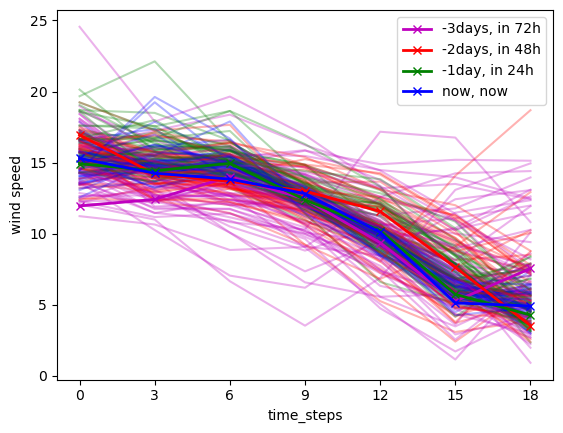

In [29]:
plt.figure()

step0 = 24
step1 = 16
step2 = 8
step3 = 0

plt_0 = ws_ecmwf_0c[step0:]
len0 = plt_0.shape[0]
plt_1 = ws_ecmwf_1c[step1:step1+len0]
plt_2 = ws_ecmwf_2c[step2:step2+len0]
plt_3 = ws_ecmwf_3c[step3:step3+len0]
plt_time = np.linspace(0,(len0-1)*3, len0)

for i in range(ws_ecmwf_0.shape[0]):
    plt_0 = ws_ecmwf_0[i, step0:]
    plt_1 = ws_ecmwf_1[i, step1:step1+len0]
    plt_2 = ws_ecmwf_2[i, step2:step2+len0]
    plt_3 = ws_ecmwf_3[i, step3:step3+len0]

    plt.plot(plt_time, plt_0, 'm', alpha = 0.3)
    plt.plot(plt_time, plt_1, 'r', alpha = 0.3) 
    plt.plot(plt_time, plt_2, 'g', alpha = 0.3) 
    plt.plot(plt_time, plt_3, 'b', alpha = 0.3)

plt.plot(plt_time, plt_0, 'mx-', linewidth=2, label='-3days, in 72h')
plt.plot(plt_time, plt_1, 'rx-', linewidth=2, label='-2days, in 48h')
plt.plot(plt_time, plt_2, 'gx-', linewidth=2, label='-1day, in 24h') 
plt.plot(plt_time, plt_3, 'bx-', linewidth=2, label='now, now')

plt.legend()
plt.xticks(plt_time)
plt.xlabel('time_steps')
plt.ylabel('wind speed')
plt.show()

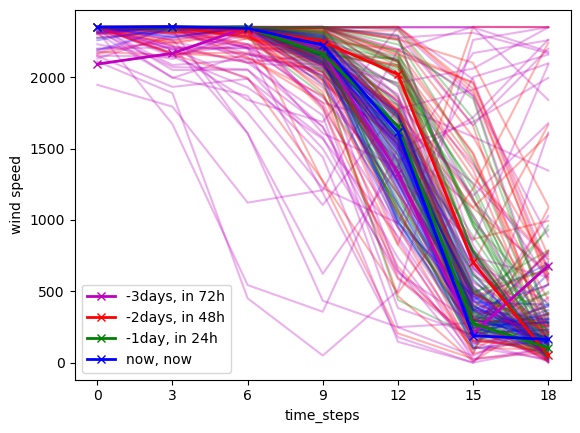

In [40]:
from scipy import interpolate
from scipy.stats import norm

wind_speed = np.linspace(0,25,51)
performance = np.array([0, 0, 0, 0, 3, 10, 25, 49, 82, 123, 174, 240, 321, 418, 532, 664, 815, 988, 1180, 1384, 1580, 1749, 1890, 2005, 2100, 2180, 2250, 2311, 2350, 2350, 2350, 2350, 2350, 2350, 2350, 2350, 2350, 2350, 2350, 2350, 2350, 2350, 2350, 2350, 2350, 2350, 2350, 2350, 2350, 2350, 2350])

interp_perf = interpolate.UnivariateSpline(wind_speed, performance, s=0)
def convert_wind_to_performance(ws):
    return interp_perf(ws)

plt.figure()

step0 = 24
step1 = 16
step2 = 8
step3 = 0

plt_0 = ws_ecmwf_0c[step0:]
len0 = plt_0.shape[0]
plt_1 = ws_ecmwf_1c[step1:step1+len0]
plt_2 = ws_ecmwf_2c[step2:step2+len0]
plt_3 = ws_ecmwf_3c[step3:step3+len0]
plt_time = np.linspace(0,(len0-1)*3, len0)

for i in range(ws_ecmwf_0.shape[0]):
    plt_0 = ws_ecmwf_0[i, step0:]
    plt_1 = ws_ecmwf_1[i, step1:step1+len0]
    plt_2 = ws_ecmwf_2[i, step2:step2+len0]
    plt_3 = ws_ecmwf_3[i, step3:step3+len0]

    plt.plot(plt_time, interp_perf(plt_0), 'm', alpha = 0.3)
    plt.plot(plt_time, interp_perf(plt_1), 'r', alpha = 0.3) 
    plt.plot(plt_time, interp_perf(plt_2), 'g', alpha = 0.3) 
    plt.plot(plt_time, interp_perf(plt_3), 'b', alpha = 0.3)

plt.plot(plt_time, interp_perf(plt_0), 'mx-', linewidth=2, label='-3days, in 72h')
plt.plot(plt_time, interp_perf(plt_1), 'rx-', linewidth=2, label='-2days, in 48h')
plt.plot(plt_time, interp_perf(plt_2), 'gx-', linewidth=2, label='-1day, in 24h')
plt.plot(plt_time, interp_perf(plt_3), 'bx-', linewidth=2, label='now, now')

plt.legend()
plt.xticks(plt_time)
plt.xlabel('time_steps')
plt.ylabel('wind speed')
plt.show()

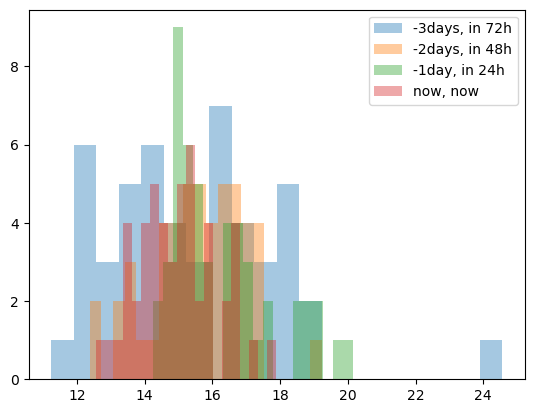

In [42]:
step0 = 24 #in 72h
step1 = 16 #in 48h
step2 = 8 #in 24h
step3 = 0 #now

plt_0 = ws_ecmwf_0[:,step0]
plt_1 = ws_ecmwf_1[:,step1]
plt_2 = ws_ecmwf_2[:,step2]
plt_3 = ws_ecmwf_3[:,step3]

plt.figure()
plt.hist(plt_0, bins=20, alpha = 0.4, label='-3days, in 72h')
plt.hist(plt_1, bins=20, alpha = 0.4, label='-2days, in 48h')
plt.hist(plt_2, bins=20, alpha = 0.4, label='-1day, in 24h')
plt.hist(plt_3, bins=20, alpha = 0.4, label='now, now')
plt.legend()
plt.show()

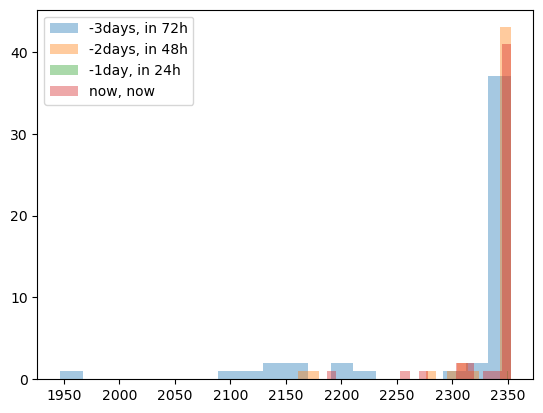

In [41]:
step0 = 24 #in 72h
step1 = 16 #in 48h
step2 = 8 #in 24h
step3 = 0 #now

plt_0 = ws_ecmwf_0[:,step0]
plt_1 = ws_ecmwf_1[:,step1]
plt_2 = ws_ecmwf_2[:,step2]
plt_3 = ws_ecmwf_3[:,step3]

plt.figure()
plt.hist(interp_perf(plt_0), bins=20, alpha = 0.4, label='-3days, in 72h')
plt.hist(interp_perf(plt_1), bins=20, alpha = 0.4, label='-2days, in 48h')
plt.hist(interp_perf(plt_2), bins=20, alpha = 0.4, label='-1day, in 24h')
plt.hist(interp_perf(plt_3), bins=20, alpha = 0.4, label='now, now')
plt.legend()
plt.show()

<AxesSubplot: >

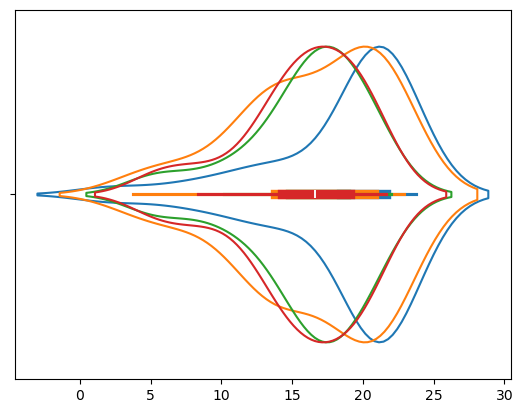

In [55]:
import seaborn as sns

sns.violinplot(x=ws_ecmwf_0c, fill=False)
sns.violinplot(x=ws_ecmwf_1c, fill=False)
sns.violinplot(x=ws_ecmwf_2c, fill=False)
sns.violinplot(x=ws_ecmwf_3c, fill=False)

<AxesSubplot: >

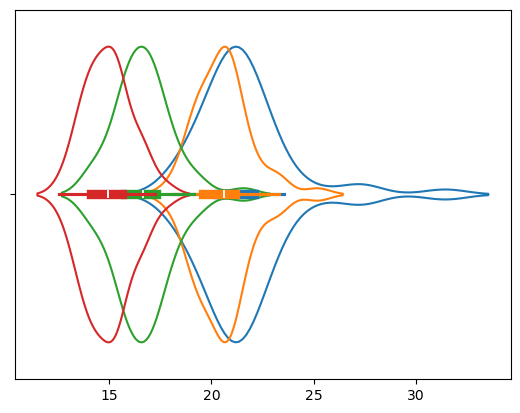

In [64]:
stp = 0

sns.violinplot(x=ws_ecmwf_0[:,stp], fill=False)
sns.violinplot(x=ws_ecmwf_1[:,stp], fill=False)
sns.violinplot(x=ws_ecmwf_2[:,stp], fill=False)
sns.violinplot(x=ws_ecmwf_3[:,stp], fill=False)

<AxesSubplot: >

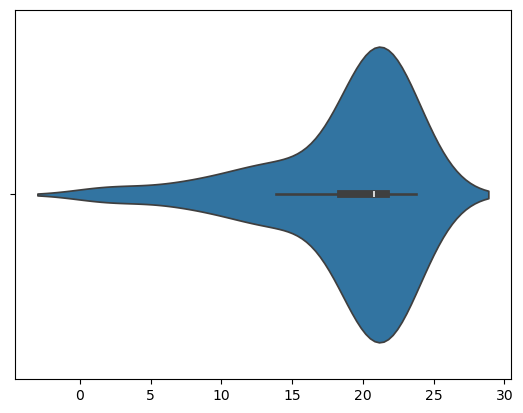

In [51]:
sns.violinplot(x=ws_ecmwf_0c)

<AxesSubplot: >

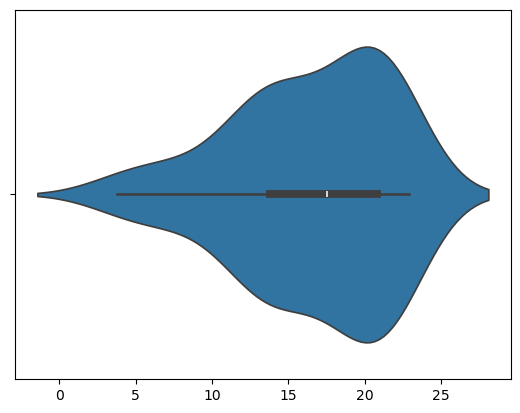

In [47]:
sns.violinplot(x=ws_ecmwf_1c)

<AxesSubplot: >

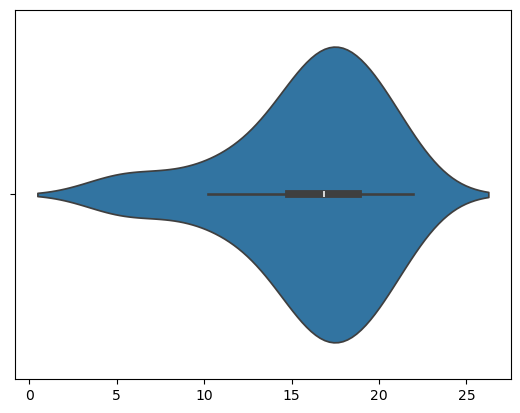

In [48]:
sns.violinplot(x=ws_ecmwf_2c)

<AxesSubplot: >

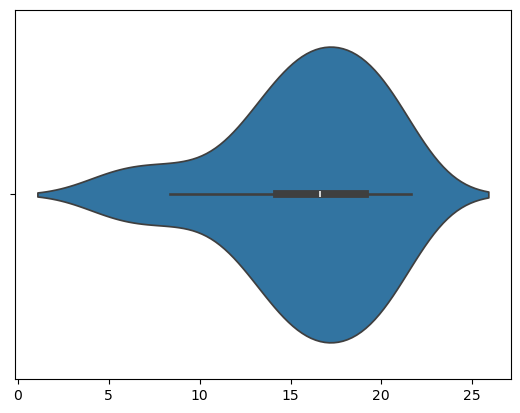

In [49]:
sns.violinplot(x=ws_ecmwf_3c)